In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas_datareader as web
import math
import yfinance as yf
import pandas as pd
import seaborn as sns

In [2]:
from keras import Input
from keras import layers
from tensorflow.keras.optimizers import RMSprop

In [10]:
import sys
#sys.path.append('../..')

#import ep.etools as apt

In [39]:
dataCalendar = pd.read_csv('./data/bloc_ttf_calendar_prices.csv')
dataPrices = pd.read_csv('./data/bloc_ttf_prices.csv')
dataPrices[' '] = pd.to_datetime(dataPrices[' '])
dataPrices = dataPrices.set_index(' ')


In [42]:
dataPrices['moy20'] = dataPrices['Day-ahead'].rolling(20).mean()

<Axes: xlabel=' '>

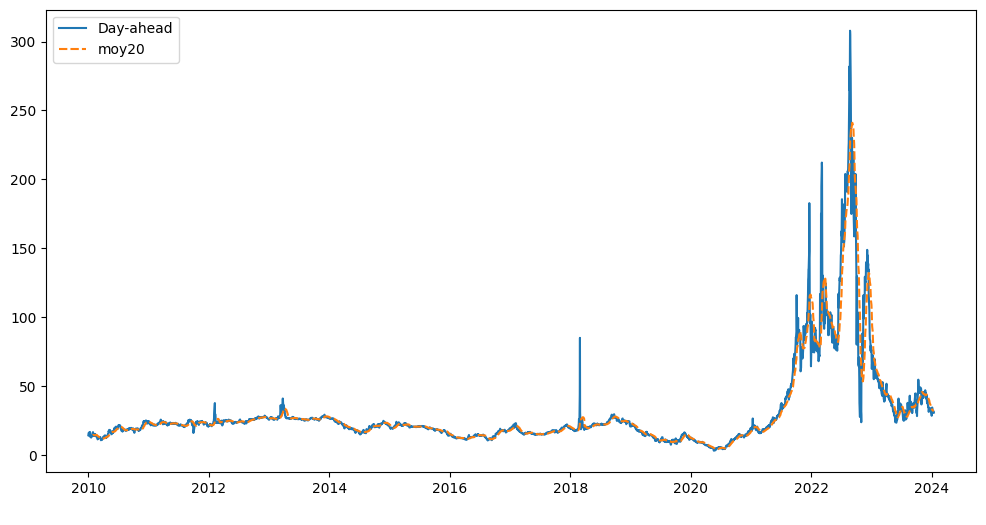

In [43]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(dataPrices[['Day-ahead','moy20']], color='Blue')
#ax2 = plt.twinx()
#sns.lineplot(data=final['€/$'], ax=ax2 , color='grey')

<Axes: xlabel=' '>

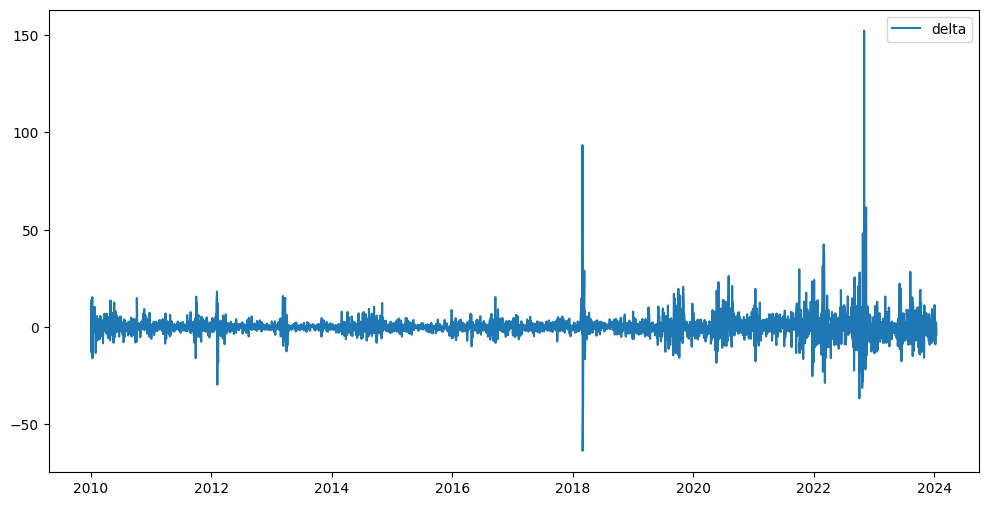

In [71]:
#Variation en %
dataPrices['delta'] =dataPrices['Day-ahead'].rolling(2).apply(lambda x: (x.iloc[1] - x.iloc[0])/x.iloc[0]*100)
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(dataPrices[['delta']], color='Blue')


In [77]:
dataPrices['delta'].std()

6.0295968222450105

<Axes: >

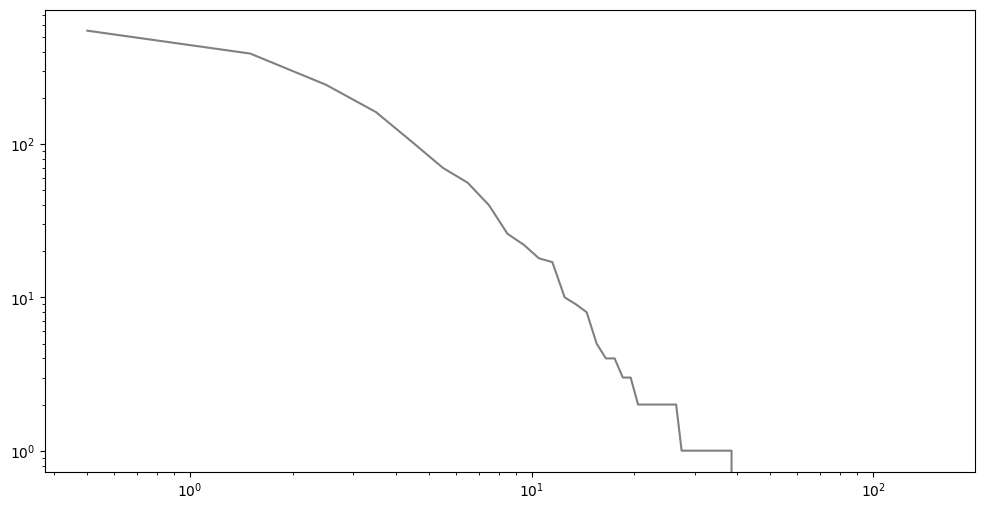

In [78]:
df= dataPrices['delta'].value_counts(bins=100)
# create intervals
bins = pd.interval_range(0, 150, freq=1)
# assign each value in df["column"] to bin and count bin occurences
counts = pd.cut(dataPrices['delta'], bins).value_counts()
# create a Series, indexed by interval midpoints and convert to dictionary
pdS = pd.Series(counts.values, index=bins.mid).to_dict()

fig, ax = plt.subplots(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
sns.lineplot(pdS, color='Grey')